In [1]:
import numpy as np
import dit
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ising import *

C:\Users\Tiago Martinelli\Meu Drive (tiago.martinelli@usp.br)\python modules\syndisc_master


In [2]:
from itertools import chain, combinations
from dit.multivariate import total_correlation as I
from joblib import Parallel, delayed

def cmi_vector(N, D):
    syn_order = []
    cmi = []        
    for source in range(0, N-1):
        for k in combinations(range(N-1), source+1):
            for index in k:
                cond_set = [x for x in k if x != index]
                syn_order.append(len(cond_set)+1)
                CMI = I(D, [[index], [N-1]], cond_set)
                print('CMI from', [index], 'to', [N-1],'conditioned on', cond_set, ':', CMI)
                                 
                cmi.append(CMI)
                
    return cmi

def cmi_optimized(N, D):
    
    def cmi_func(m, N, D):
        i = []
        syn_order = []
        for k in combinations(range(N-1), m):
            for j in list(k):
                cond_set = [x for x in list(k) if x!=j]
                syn_order.append(len(cond_set)+1)
                cmi = I(D, [[j], [N-1]], cond_set)
                print('CMI from', [j], 'to', [N-1],'conditioned on', cond_set, ':', cmi)
                i.append([j, cond_set, cmi])
                
        return i           
    
    res = Parallel(n_jobs=os.cpu_count())(delayed(cmi_func)(m, N, D) for m in range(1, N))
    return list(chain(*res))

# Unfaithful toy model 

In [ ]:
outcomes_c = ['0000', '1001', '0101', '1100', '0011', '1011', '0111', '1111']

I03, I13, I23 = [], [], []
I03g2, I13g2 = [], []
cmi = {}
F = np.linspace(start=0, stop=1, num=1000)
for f in F:
    pmf_c = [1/8*f, 1/8*f, 3/8*f, 3/8*f, 1/8*(1-f), 1/8*(1-f), 3/8*(1-f), 3/8*(1-f)]
    mixed_dXOR = dit.Distribution(outcomes_c, pmf_c)
    cmi[f] = cmi_optimized(4, mixed_dXOR)


In [ ]:
cond =[]
for row in cmi[0]:
    #print(row[1])
    if len(row[1]) == 0:
        cond.append(row[1])
    else:
        cond.append([x+1 for x in row[1]])
    
print(cond)
source = [[row[0]+1] for row in cmi[0]]
source
nodes = [[s, c] for s,c in zip(source, cond)]
nodes
nodes_str = [str(x) for x in nodes]
nodes_str

In [ ]:
CMI = {}
for f in F:
    CMI[f] = [row[2] for row in cmi[f]]
              
I = pd.DataFrame(CMI)
I = I.T

column_indices = list(range(len(nodes)))
new_names = nodes_str
old_names = I.columns[column_indices]
I.rename(columns=dict(zip(old_names, new_names)), inplace=True)
#I.to_pickle('data\CMI_SimpleModelN3.pkl')
I

In [ ]:
fig = plt.figure()

plt.subplot(121)
plt.plot(F, I['[[1], []]'], '-', color='c', label='$MI(X_{1},Y)$')
plt.plot(F, I['[[2], []]'], '-', color='r', label='$MI(X_{2},Y)$')
plt.plot(F, I['[[3], []]'], '-', color='orange', label='$MI(X_{3},Y)$')
#plt.xlabel('$f$', fontsize=18)
plt.minorticks_on()
plt.tick_params(which='both', axis='both', direction='in', labelsize=14)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='black') 
plt.legend(fontsize=13, loc='best', bbox_to_anchor=(0.4, 0.5, 0.6, 0.5))

plt.subplot(122)
plt.plot(F, I['[[2], [1, 3]]'], '-', color='r', label='$CMI(X_{2},Y|X_{1}, X_{3})$')
plt.minorticks_on()
plt.tick_params(which='both', axis='both', direction='in', labelsize=14)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='black') 
plt.legend(fontsize=13, loc='upper left', bbox_to_anchor=(0., 1))

fig.set_size_inches(11, 4.5)
plt.tight_layout()
#plt.savefig('figures\mixedXOR_FM.pdf', bbox_inches='tight')
plt.show()


#  CMI analysis Higher-Order Ising Model

## pure synergic Ising systems

In [ ]:
n_spins=5
samples = 50

for k in range(2, n_spins+1):  
    
    order = 0.1*np.eye(1, n_spins-1, k-2)[0]
    MI = {}
    CMI = [[] for x in range(samples)]
    for i in range(samples):
        d = HighOrder_DirectedIsing(n_spins, order)
        MI[i] = I(d, [list(range(n_spins-1)), [n_spins-1]])
        res = cmi_optimized(n_spins, d)
        CMI[i] = [row[2] for row in res]
        print(MI[i])

    MI_avg = np.mean(list(MI.values()))
    CMI_avg = np.mean(np.array(CMI), axis=0)
    CMI_err = np.std(np.array(CMI), axis=0)

    df = pd.DataFrame(res)
    df.columns = ["Node", "Cond_set", "CMI"]
    df.CMI = CMI_avg
    df["CMI_err"] = CMI_err
    df["MI"] = MI_avg  
    print(df)
    #df.to_pickle('data\CMI_N%ik%i_samples%i.pkl' %(n_spins, k, samples))
 

In [ ]:
n_spins=5
samples=25

df={}
mi=[]
for k in range(2, n_spins+1):
    pkl_file = open('data\CMI_N%ik%i_samples%i.pkl' %(n_spins, k, samples), 'rb')
    df[k] = pkl.load(pkl_file)
    pkl_file.close() 
    print(df[k]['MI'][0])
    mi.append(df[k]['MI'][0])
    df[k]['Order'] = df[k]['Cond_set'].apply(len)+2 
    #print(df[k-2])
    df[k] = df[k].drop(['Node', 'Cond_set', 'MI'], axis=1)
    df[k] = df[k].sort_values(by=['Order']).reset_index(drop=True)
    df[k] = df[k].groupby('Order').mean()
    
print(df)
print(mi)
for k in range(2, n_spins+1):
    df[k]['CMI'] = df[k]['CMI']/mi[k-2]

df

In [ ]:
new_df = pd.concat([df[k] for k in range(2, n_spins+1)], keys=['%i' %k for k in range(2, n_spins+1)])
#new_df.to_csv('CMIs.csv')
new_df

In [ ]:
dfr = pd.read_csv("CMIs.csv")
dfr.columns =['Order', 'Cond_set', 'CMI']

print(dfr)

In [5]:
import matplotlib as mpl

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'palatino')

## Plotting second paper figure

NameError: name 'n_spins' is not defined

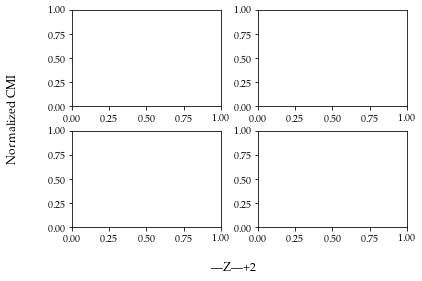

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2)#, sharex=True, sharey=True, figsize=(7, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.25)
fig.text(0.5, -0.025, '|Z|+2', ha='center', fontsize=12)
fig.text(-0.025, 0.5, 'Normalized CMI', va='center', rotation='vertical', fontsize=12)

axs[0, 0].bar(range(2, n_spins+1), df[2].CMI.to_list(), color='blue')
axs[0, 0].set_title('Interaction order $k= 2$')
axs[0, 1].bar(range(2, n_spins+1), df[3].CMI.to_list(), color='orange')
axs[0, 1].set_title('Interaction order $k= 3$')
axs[1, 0].bar(range(2, n_spins+1), df[4].CMI.to_list(), color='green')
axs[1, 0].set_title('Interaction order $k= 4$')
axs[1, 1].bar(range(2, n_spins+1), df[5].CMI.to_list(), color='red')
axs[1, 1].set_title('Interaction order $k= 5$')

for ax in fig.get_axes():
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=.5)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4, color='black') 
    ax.tick_params(axis='y', which='minor')
    ax.tick_params(which='both', axis='both', direction='in')
    ax.set_xticks(range(2, n_spins+1))
    
axs[0, 0].xaxis.label.set_visible(False)
axs[0, 1].xaxis.label.set_visible(False)
fig.set_size_inches(5, 4)
plt.tight_layout()
#plt.savefig('down_faithfulness.pdf', bbox_inches='tight', dpi=100)

# Sparse versus Dense systems

## Simple model

To start with a high order case, we model non-pairwise components \textit{exclusively} in the Hamiltonian of a spin systems, up to orer $k=4$ here, among the set of the six nodes  $\{X_{1},X_{2},\ldots, X_{6}\}$ where the last node, $X_{6}$, is always considered as a target, 

$$ H = -J_{2} X_{0}X_{6} -J_{3}X_{1}X_{2}X_{6} -J_{4}X_{3}X_{4}X_{5}X_{6}$$

Generalizing for a set of $N$ parents $\{X_{1},X_{2},\ldots, X_{N}\}$, we have,

$$ H = -X_{N}\sum_{k} J_{k}\prod_{i\in \mathbf{I}}X_{i} , $$
     
with the last sum running over all collections of the exclusivity antichain (defined in my dissertation) and the set $\mathbf{I}$ consider the $k$-th order product of the nodes $X_{i}X_{i+1}\ldots X_{i+k-1}$ exclusively.

In [16]:
N=10
samples=1

MI = {}
CMI = {}
for i in range(samples):
    d_simple = Simple_HO_DirectedIsing(N, std2=0.2, std3=0.2, std4=0.2, std5=0.2)
    MI[i] = I(d_simple, [list(range(N)), [N]])
    print('MI[%i] from the joint vector' %i, list(range(N)), 'to', [N],':', MI[i])
    res = cmi_optimized(N+1, d_simple)
    df = pd.DataFrame(res)
    df.columns = ['Node', 'Cond_set', 'CMI'] 
    df['Order'] = df['Cond_set'].apply(len)+1
    
    CMI[i] = df
    CMI[i] = CMI[i].drop(['Node', 'Cond_set'], axis=1)
    CMI[i] = CMI[i].sort_values(by=['Order']).reset_index(drop=True)
    CMI[i] = CMI[i].groupby('Order').mean()
    
table = pd.concat((CMI[i] for i in CMI))
print(table)
table = table.groupby('Order').aggregate([np.mean, np.std]).reset_index()
table.columns = table.columns.map(lambda l: ' '.join(l).strip())
#table.to_pickle('data\SimpleHighOrderIsing%isamples%i_CMI_Jx2.pkl' %(N, samples))
table

MI[0] from the joint vector [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] to [10] : 0.052055972925005634


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
plt.errorbar(table['Order']+1, table['CMI mean'], yerr=table['CMI std'], fmt='-o', color='Red', elinewidth=.75, capthick=.5, capsize=2, errorevery=1, ms=6)
plt.minorticks_on()
plt.xlabel('Order') ## Label on X axis
plt.ylabel('CMI mean')
ax.tick_params(which='both', axis='both', direction='in')
plt.xticks(np.arange(2, N+1, 1, dtype=int))
#plt.savefig('figures\CMI_increasing_curveN%i_SimpleModel_samples%i.pdf' %(N, samples), bbox_inches='tight')
plt.show()

## Dense model

To get to the high order case, we need overcoming the pairwise interactions . We model this by by adding non-pairwise components to the Hamiltonian:

$$ H = -\sum_{i=1}^{n+1} J_{i} \sigma_{i} -\sum_{i=1}^{n}\sum_{j=i+1}^{n+1} J_{ij} \sigma_i \sigma_{j} - \ldots -\sum_{|\mathbf{I}=k|} J_{\gamma}\prod_{i \in \mathbf{I}} \sigma_i,  $$
     
with the last sum running over all collections of indices $\mathbf{I}\subseteq [n+1]$ of cardinality $|\gamma| = k$.

In [13]:
N=5
samples=10
std=0.2

J=[]
for i in range(0, N):
    #J.append(std*(N-i)*np.eye(1, N, k=i)[0])
    #J.append(std*(i+1)*np.eye(1, N, k=i)[0])
    J.append(std*1*np.eye(1, N, k=i)[0])
J = sum(J)
print(J)

MI = {}
CMI = {}
for i in range(samples):
    order=J
    d = HighOrder_DirectedIsing(N, order)
    MI[i] = I(d, [list(range(N-1)), [N-1]])
    print('MI[%i] from the joint vector' %i, list(range(N-1)), 'to', [N-1],':', MI[i])
    res = cmi_optimized(N, d)
    df = pd.DataFrame(res)
    df.columns = ['Node', 'Cond_set', 'CMI'] 
    df['Order'] = df['Cond_set'].apply(len)+2
    df['MI'] = np.vstack([MI[i] for _ in range(len(df))])
    CMI[i] = df
    
print(CMI)

[0.2 0.2 0.2 0.2 0.2]
MI[0] from the joint vector [0, 1, 2, 3] to [4] : 0.25111060165968446
MI[1] from the joint vector [0, 1, 2, 3] to [4] : 0.27789945835205554
MI[2] from the joint vector [0, 1, 2, 3] to [4] : 0.2071505063851058
MI[3] from the joint vector [0, 1, 2, 3] to [4] : 0.2737306633719996
MI[4] from the joint vector [0, 1, 2, 3] to [4] : 0.17467653647819947
MI[5] from the joint vector [0, 1, 2, 3] to [4] : 0.15688511839632824
MI[6] from the joint vector [0, 1, 2, 3] to [4] : 0.29381724769434037
MI[7] from the joint vector [0, 1, 2, 3] to [4] : 0.2765577373332375
MI[8] from the joint vector [0, 1, 2, 3] to [4] : 0.27243668240369256
MI[9] from the joint vector [0, 1, 2, 3] to [4] : 0.2951502317448913
{0:     Node   Cond_set       CMI  Order        MI
0      0         []  0.090832      2  0.251111
1      1         []  0.058961      2  0.251111
2      2         []  0.066321      2  0.251111
3      3         []  0.053792      2  0.251111
4      0        [1]  0.082754      3  0.251

In [14]:
import pickle as pkl

mi = np.mean([CMI[i].MI[0] for i in range(samples)])

for i in range(samples):

    CMI[i] = CMI[i].drop(['Node', 'Cond_set', 'MI'], axis=1)
    CMI[i] = CMI[i].sort_values(by=['Order']).reset_index(drop=True)
    CMI[i] = CMI[i].groupby('Order').mean()
    
table = pd.concat((CMI[i] for i in CMI))
print(table)
#table.CMI = table.CMI/mi
#print(table)
table = table.groupby('Order').aggregate([np.mean, np.std]).reset_index()
table.columns = table.columns.map(lambda l: ' '.join(l).strip())
#table.to_pickle('data\HighOrderIsingN%i_samples%igroupedCMI_decreaseJs.pkl' %(N, samples))
table

            CMI
Order          
2      0.067476
3      0.065868
4      0.057911
5      0.059855
2      0.082274
3      0.077466
4      0.063782
5      0.054377
2      0.047606
3      0.053401
4      0.051740
5      0.054404
2      0.080932
3      0.074749
4      0.057905
5      0.060145
2      0.029367
3      0.041088
4      0.046023
5      0.058198
2      0.032603
3      0.038041
4      0.043080
5      0.043162
2      0.081990
3      0.082800
4      0.065765
5      0.063262
2      0.072155
3      0.075960
4      0.066333
5      0.062110
2      0.081316
3      0.076058
4      0.062867
5      0.052196
2      0.071173
3      0.083525
4      0.071726
5      0.068726


,Order,CMI mean,CMI std
0,2,0.064689,0.020611
1,3,0.066896,0.016835
2,4,0.058713,0.009282
3,5,0.057643,0.007042


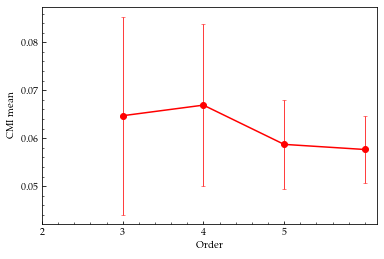

In [15]:
fig, ax = plt.subplots()
plt.errorbar(table['Order']+1, table['CMI mean'], yerr=table['CMI std'], fmt='-o', color='Red', elinewidth=.75, capthick=.5, capsize=2, errorevery=1, ms=6)
plt.minorticks_on()
plt.xlabel('Order') ## Label on X axis
plt.ylabel('CMI mean')
ax.tick_params(which='both', axis='both', direction='in')
plt.xticks(np.arange(2, N+1, 1, dtype=int))
#plt.savefig('figures\CMI_increasing_curveN%i_SimpleModel_samples%i.pdf' %(N, samples), bbox_inches='tight')
plt.show()

# Plotting figures

In [6]:
N, samples = {}, {}
(N[0], samples[0]) = 11, 100
(N[1], samples[1]) = 12, 100

pkl_file = open('data\SimpleHighOrderIsing%isamples%i_CMI.pkl' %(N[0], samples[0]), 'rb')
table1 = pkl.load(pkl_file)
pkl_file.close()
table2 = pd.read_pickle('data\HighOrderIsingN%i_samples%igroupedCMI.pkl' %(N[1], samples[1]))

In [7]:
table1.to_csv('Sparse high-order interactions.csv', index=None)
table2.to_csv('Dense high-order interactions.csv', index=None)

In [8]:
read1 = pd.read_csv('Sparse high-order interactions.csv')
read2 = pd.read_csv('Dense high-order interactions.csv')

read2

,Order,CMI mean,CMI std
0,2,0.122035,0.109065
1,3,0.119245,0.073371
2,4,0.105874,0.061755
3,5,0.084461,0.053446
4,6,0.061112,0.041985
5,7,0.040611,0.029891
6,8,0.025144,0.019839
7,9,0.014740,0.012642
8,10,0.008313,0.008066
9,11,0.004554,0.005558


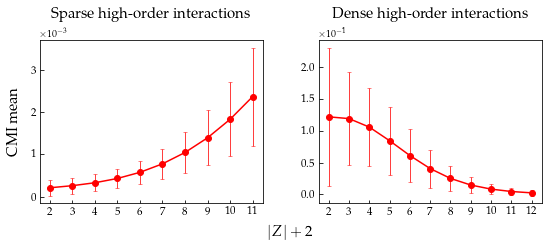

In [12]:
#import matplotlib.ticker as mtick

N, samples = {}, {}
(N[0], samples[0]) = 11, 100
(N[1], samples[1]) = 12, 100

pkl_file = open('data\SimpleHighOrderIsing%isamples%i_CMI.pkl' %(N[0], samples[0]), 'rb')
table1 = pkl.load(pkl_file)
pkl_file.close()
table2 = pd.read_pickle('data\HighOrderIsingN%i_samples%igroupedCMI.pkl' %(N[1], samples[1]))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))#, sharex=True, sharey=True,
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.15)
fig.text(0.075, 0.5, 'CMI mean', va='center', rotation='vertical', fontsize=15)
fig.text(0.5125, -0.025, r'$|Z|+2$', ha='center', rotation='horizontal', fontsize=15)

axs[0].errorbar(range(2, N[0]+1), table1['CMI mean'], yerr=table1['CMI std'], fmt='-o', color='Red', elinewidth=.75, capthick=.5, capsize=2, errorevery=1, ms=6)
axs[0].set_title('Sparse high-order interactions', y=1.1, fontsize=15)
axs[1].errorbar(range(2, N[1]+1), table2['CMI mean'], yerr=table2['CMI std'], fmt='-o', color='Red', elinewidth=.75, capthick=.5, capsize=2, errorevery=1, ms=6)
axs[1].set_title('Dense high-order interactions', y=1.1, fontsize=15)

for i, axs in enumerate(fig.get_axes()):
    axs.tick_params(which='both', axis='both', direction='in', labelsize=11)
    #axs.set(xlabel='# variables in CMI (samples=%i)' %samples[i])
    axs.set_xticks(range(2, N[i]+1))
    axs.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
    #axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
#plt.errorbarplt.minorticks_on()

plt.savefig('Sparse-dense high-order interactions.pdf', bbox_inches='tight', dpi=100)

plt.show()